In [1]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
import numpy as np

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

batch_size = 32  # Adjust according to your requirements
data_root = "./content/"  # Path to your custom dataset root directory

# Define transformations to be applied to the images
data_transform = transforms.Compose([
    transforms.Resize((223, 217)),  # Resize images to a standard size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Load the custom dataset
custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)

# Split the dataset into train and test
# You can define a custom train/test split or use the whole dataset for training
# Here, I'm using the same dataset for both training and testing, but you can split it differently if needed.
train_dataset = custom_dataset

# Define data loaders for train and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Check the length of the dataset
print("Number of training samples:", len(train_dataset))

Number of training samples: 1862


In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

batch_size = 32  # Adjust according to your requirements
data_root = "./test/"  # Path to your custom dataset root directory

# Define transformations to be applied to the images
data_transform = transforms.Compose([
    transforms.Resize((223, 217)),  # Resize images to a standard size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values
])

# Load the custom dataset
custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)

# Split the dataset into train and test
# You can define a custom train/test split or use the whole dataset for training
# Here, I'm using the same dataset for both training and testing, but you can split it differently if needed.
test_dataset = custom_dataset

# Define data loaders for train and test datasets
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle test data

# Check the length of the dataset
print("Number of test samples:", len(test_dataset))

Number of test samples: 138


In [4]:
import  matplotlib.pyplot as plt

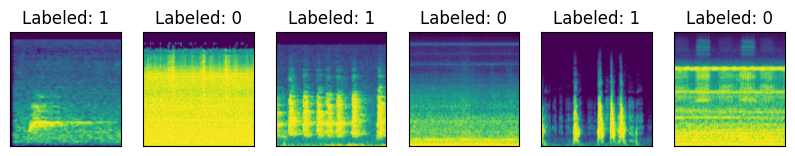

In [5]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy())
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [6]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [7]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2, reps=5)
    ansatz = RealAmplitudes(2, reps=5)
    qc = QuantumCircuit(3)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [8]:
# Define torch NN module

class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(3, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(42432, 64)  # Adjust the input size to match the flattened output size
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return torch.cat((x, 1 - x), -1)


model4 = Net(qnn4)

In [9]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.0001)
loss_func = CrossEntropyLoss()

# Start training
epochs = 25  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [4%]	Loss: 0.7474
Training [8%]	Loss: 0.7655
Training [12%]	Loss: 0.7503
Training [16%]	Loss: 0.7601
Training [20%]	Loss: 0.7498
Training [24%]	Loss: 0.7237
Training [28%]	Loss: 0.7573
Training [32%]	Loss: 0.7489
Training [36%]	Loss: 0.7106
Training [40%]	Loss: 0.7328
Training [44%]	Loss: 0.7338
Training [48%]	Loss: 0.7511
Training [52%]	Loss: 0.7476
Training [56%]	Loss: 0.7285
Training [60%]	Loss: 0.7405
Training [64%]	Loss: 0.7593
Training [68%]	Loss: 0.7305
Training [72%]	Loss: 0.7366
Training [76%]	Loss: 0.7435
Training [80%]	Loss: 0.7372
Training [84%]	Loss: 0.7439
Training [88%]	Loss: 0.7283
Training [92%]	Loss: 0.7331
Training [96%]	Loss: 0.7321
Training [100%]	Loss: 0.7242


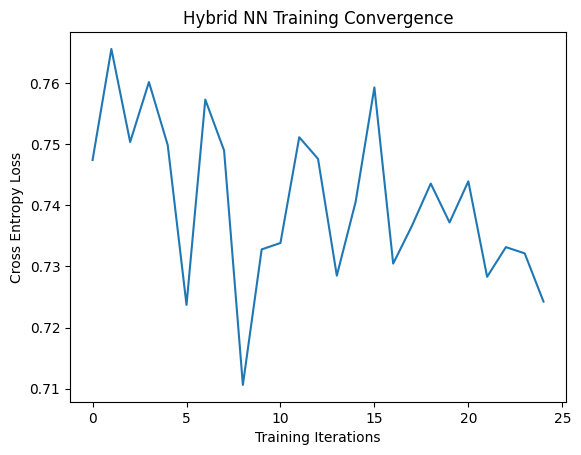

In [10]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [11]:
model4.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model4(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: 0.7280
	Accuracy: 37.5%


In [12]:
model4.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        output = model4(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on train data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(train_loader) / batch_size * 100
        )
    )

Performance on train data:
	Loss: 0.7386
	Accuracy: 47.8%
